In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle
# imports KFold from sklearn.model_selection
from sklearn.model_selection import KFold
# imports ColumnTransformer from sklearn.compose
from sklearn.compose import ColumnTransformer
# imports Pipeline from sklearn.pipeline
from sklearn.pipeline import Pipeline
# imports StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

file = open('../data/data_prep_gt.save', 'rb')
other_sets_gt, test_sets_gt = pickle.load(file)
file.close()

In [2]:
# converts data in the excel file into pandas dataframe
dfff = pd.read_csv(r'/Users/jamesro/Documents/DATA1030-Fall2021/Data-1030-Project/Data/student-mat.csv',sep=';')
# converts G3 into binary scale
pass_final = dfff.G3 >= 10
fail_final = dfff.G3 < 10
dfff.loc[pass_final,'G3'] = 1
dfff.loc[fail_final,'G3'] = 0
# drop G1 and G2 features
dfff.drop('G1', axis=1, inplace=True)
dfff.drop('G2', axis=1, inplace=True)
print(dfff)
yyy = dfff['G3']
XXX = dfff.loc[:, dfff.columns != 'G3']

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... internet romantic  famrel  freetime  goout

In [3]:
# imports pandas package
import pandas as pd
# imports numpy package
import numpy as np
# imports matplotlib package
import matplotlib
# imports pylab from matplotlib
from matplotlib import pylab as plt
# imports train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split
# imports KFold from sklearn.model_selection
from sklearn.model_selection import KFold
# imports ColumnTransformer from sklearn.compose
from sklearn.compose import ColumnTransformer
# imports Pipeline from sklearn.pipeline
from sklearn.pipeline import Pipeline
# imports StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

onehot_ftrs = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
minmax_ftrs = ['age','absences']
std_ftrs = ['Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)
        ])

def MLpipe_KFold_Accu(preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    nr_states = 10
    test_scores = np.zeros(nr_states)
    best_models = []

    for i in range(nr_states):
        
        X_other, y_other = other_sets_gt[i]
        X_test, y_test = test_sets_gt[i]

        kf = KFold(n_splits=4,shuffle=True,random_state=42*i)
         
        pipe = make_pipeline(preprocessor,ML_algo)
        
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        print('best model parameters:',grid.best_params_)
        
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model
        best_models.append(grid)
        # calculate RMSE value for test set
        y_test_pred = best_models[-1].predict(X_test)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])
        
    return best_models, test_scores, grid, X_test, y_test

In [4]:
print(dfff.G3.value_counts())


baseline_accuracy = dfff.G3.value_counts()[1]/len(dfff)
print("baseline accuracy score: ", baseline_accuracy)

1    265
0    130
Name: G3, dtype: int64
baseline accuracy score:  0.6708860759493671


In [5]:
from sklearn.linear_model import LogisticRegression
import math 

l1_param_grid = {
                 'logisticregression__C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                 'logisticregression__max_iter': [10e5]
                 } 

L1R = LogisticRegression(penalty='l1', solver='saga')
l1_best_models, l1_test_scores, l1_grid, l1_X_test, l1_y_test = MLpipe_KFold_Accu(preprocessor, L1R, l1_param_grid)

l1_mean = np.mean(l1_test_scores)
l1_std = np.std(l1_test_scores)

print('mean test score: ',l1_mean)
print('std of test score: ',l1_std)
print('95% Confidence Interval: ',(l1_mean - 1.96*(l1_std/math.sqrt(5)), l1_mean + 1.96*(l1_std/math.sqrt(5))))
print('standard deviations from baseline: ',(l1_mean - baseline_accuracy)/l1_std)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7278481012658228
test score: 0.6708860759493671
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7183544303797468
test score: 0.7215189873417721
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7215189873417722
test score: 0.6962025316455697
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7151898734177216
test score: 0.7341772151898734
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregress

In [6]:
from sklearn.linear_model import LogisticRegression
import math 

l2_param_grid = {
                 'logisticregression__C': [1e-2, 1e-1, 1e0, 1e1, 1e2], 
                 'logisticregression__max_iter': [10e5]
                 } 

L2R = LogisticRegression(penalty='l2', solver='saga')
l2_best_models, l2_test_scores, l2_grid, l2_X_test, l2_y_test = MLpipe_KFold_Accu(preprocessor, L2R, l2_param_grid)

l2_mean = np.mean(l2_test_scores)
l2_std = np.std(l2_test_scores)

print('mean test score: ',l2_mean)
print('std of test score: ',l2_std)
print('95% Confidence Interval: ',(l2_mean - 1.96*(l2_std/math.sqrt(5)), l2_mean + 1.96*(l2_std/math.sqrt(5))))
print('standard deviations from baseline: ',(l2_mean - baseline_accuracy)/l2_std)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7056962025316456
test score: 0.6708860759493671
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7056962025316456
test score: 0.6582278481012658
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 1000000.0}
validation score: 0.699367088607595
test score: 0.6962025316455697
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000000.0}
validation score: 0.7025316455696202
test score: 0.7088607594936709
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best model parameters: {'logisticregres

In [7]:
from sklearn.linear_model import LogisticRegression
import math 

en_param_grid = {
                 'logisticregression__C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                 'logisticregression__l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99],
                 'logisticregression__max_iter': [10000]
                 } 

EN = LogisticRegression(penalty='elasticnet', solver='saga')
en_best_models, en_test_scores, en_grid, en_X_test, en_y_test = MLpipe_KFold_Accu(preprocessor, EN, en_param_grid)

en_mean = np.mean(en_test_scores)
en_std = np.std(en_test_scores)

print('mean test score: ',en_mean)
print('std of test score: ',en_std)
print('95% Confidence Interval: ',(en_mean - 1.96*(en_std/math.sqrt(35)), en_mean + 1.96*(en_std/math.sqrt(35))))
print('standard deviations from baseline: ',(en_mean - baseline_accuracy)/en_std)

Fitting 4 folds for each of 35 candidates, totalling 140 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.25, 'logisticregression__max_iter': 10000}
validation score: 0.7436708860759493
test score: 0.6962025316455697
Fitting 4 folds for each of 35 candidates, totalling 140 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.5, 'logisticregression__max_iter': 10000}
validation score: 0.7310126582278481
test score: 0.7341772151898734
Fitting 4 folds for each of 35 candidates, totalling 140 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.5, 'logisticregression__max_iter': 10000}
validation score: 0.7373417721518987
test score: 0.7088607594936709
Fitting 4 folds for each of 35 candidates, totalling 140 fits
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.25, 'logisticregression__max_iter': 10000}
validation score: 0.718354

In [8]:
from sklearn.ensemble import RandomForestClassifier
import math 

rfc_param_grid = {
                   'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
                   'randomforestclassifier__max_features': [0.5,0.75,1.0] 
                   } 

ML_algo = RandomForestClassifier()
rfc_best_models, rfc_test_scores, rfc_grid, rfc_X_test, rfc_y_test = MLpipe_KFold_Accu(preprocessor, ML_algo, rfc_param_grid)

rfc_mean = np.mean(rfc_test_scores)
rfc_std = np.std(rfc_test_scores)

print('mean test score: ',rfc_mean)
print('std of test score: ',rfc_std)
print('95% Confidence Interval: ',(rfc_mean - 1.96*(rfc_std/math.sqrt(15)), rfc_mean + 1.96*(rfc_std/math.sqrt(15))))
print('standard deviations from baseline: ',(rfc_mean - baseline_accuracy)/rfc_std)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
validation score: 0.7405063291139241
test score: 0.6962025316455697
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.5}
validation score: 0.7278481012658228
test score: 0.6962025316455697
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
validation score: 0.7278481012658229
test score: 0.6962025316455697
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.5}
validation score: 0.7405063291139241
test score: 0.6962025316455697
Fitting 4 folds for each of 15 candidates, tota

In [9]:
from sklearn.svm import SVC
import math 

svc_param_grid = {
                 'svc__gamma': [1000000, 1000, 1, 0.001],
                 'svc__C': [1, 10, 30, 100]
                 } 

SVC = SVC()
svc_best_models, svc_test_scores, svc_grid, svc_X_test, svc_y_test = MLpipe_KFold_Accu(preprocessor, SVC, svc_param_grid)

svc_mean = np.mean(svc_test_scores)
svc_std = np.std(svc_test_scores)

print('mean test score: ',svc_mean)
print('std of test score: ',svc_std)
print('95% Confidence Interval: ',(svc_mean - 1.96*(svc_std/math.sqrt(45)), svc_mean + 1.96*(svc_std/math.sqrt(45))))
print('standard deviations from baseline: ',(svc_mean - baseline_accuracy)/svc_std)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
best model parameters: {'svc__C': 10, 'svc__gamma': 0.001}
validation score: 0.7278481012658228
test score: 0.6835443037974683
Fitting 4 folds for each of 16 candidates, totalling 64 fits
best model parameters: {'svc__C': 30, 'svc__gamma': 0.001}
validation score: 0.7215189873417721
test score: 0.7088607594936709
Fitting 4 folds for each of 16 candidates, totalling 64 fits
best model parameters: {'svc__C': 10, 'svc__gamma': 0.001}
validation score: 0.7278481012658228
test score: 0.6962025316455697
Fitting 4 folds for each of 16 candidates, totalling 64 fits
best model parameters: {'svc__C': 10, 'svc__gamma': 0.001}
validation score: 0.7151898734177216
test score: 0.7341772151898734
Fitting 4 folds for each of 16 candidates, totalling 64 fits
best model parameters: {'svc__C': 10, 'svc__gamma': 0.001}
validation score: 0.6930379746835442
test score: 0.810126582278481
Fitting 4 folds for each of 16 candidates, totalling 64 fits


In [10]:
from sklearn.neighbors import KNeighborsClassifier
import math 

knn_param_grid = {
                   'kneighborsclassifier__n_neighbors': [1, 10, 30, 100], 
                   'kneighborsclassifier__weights': ['uniform', 'distance']
                   } 

KNN = KNeighborsClassifier()
knn_best_models, knn_test_scores, knn_grid, knn_X_test, knn_y_test = MLpipe_KFold_Accu(preprocessor, KNN, knn_param_grid)

knn_mean = np.mean(knn_test_scores)
knn_std = np.std(knn_test_scores)

print('mean test score: ',knn_mean)
print('std of test score: ',knn_std)
print('95% Confidence Interval: ',(knn_mean - 1.96*(knn_std/math.sqrt(8)), knn_mean + 1.96*(knn_std/math.sqrt(8))))
print('standard deviations from baseline: ',(knn_mean - baseline_accuracy)/knn_std)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
best model parameters: {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'uniform'}
validation score: 0.7151898734177216
test score: 0.6835443037974683
Fitting 4 folds for each of 8 candidates, totalling 32 fits
best model parameters: {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'uniform'}
validation score: 0.7151898734177216
test score: 0.6835443037974683
Fitting 4 folds for each of 8 candidates, totalling 32 fits
best model parameters: {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
validation score: 0.699367088607595
test score: 0.6835443037974683
Fitting 4 folds for each of 8 candidates, totalling 32 fits
best model parameters: {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
validation score: 0.6930379746835442
test score: 0.7088607594936709
Fitting 4 folds for each of 8 candidates, totalling

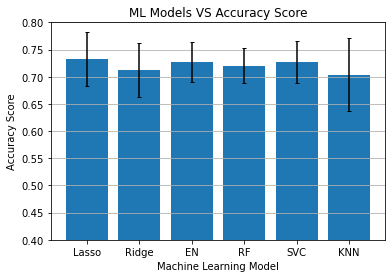

In [11]:
model_name = ["Lasso", "Ridge", "EN", "RF", "SVC", "KNN"]
mean_scores = [l1_mean, l2_mean, en_mean, rfc_mean, svc_mean, knn_mean]
stdev_scores = [l1_std, l2_std, en_std, rfc_std, svc_std, knn_std]

plt.bar(model_name, mean_scores, yerr=stdev_scores, capsize=2)
plt.ylim([0.4,0.8])
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xlabel("Machine Learning Model")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=0)
plt.title("ML Models VS Accuracy Score")
plt.savefig('../figures/mlmodels_accu_gt.jpg', dpi=300)
plt.show()